# Introduction

Here, we will demonstrate the use of generalized additive models and trees. For this work, we will be reusing our Lab 2 dataset. I will reiterate that cross-validation must be done to have any confidence in your ML models. At the very least, a proper training/test split should be done.

As we move towards the end of this course, we are going to be working with much more sophisticated tools in the scikit-learn package. Specifically, one of the things we will use extensively is [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). This class allows us to scan a set of parameter values for a model and return the CV results.

In [1]:
import collections

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from pymatgen import Composition

rcparams = {'legend.fontsize': 20,
            'figure.figsize': (12, 8),
            'axes.labelsize': 24,
            'axes.titlesize': 28,
            'xtick.labelsize':20,
            'ytick.labelsize': 20}
sns.set(rc=rcparams)
mpl.rcParams.update(rcparams)

%matplotlib inline
%config InlineBackend.figure_format ='retina'


from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import export_text, export_graphviz

from statsmodels.gam.generalized_additive_model import GLMGam
from statsmodels.gam.api import BSplines
import statsmodels.api as sm

In [2]:
# by default pandas will recognize NaN (sodium nitride) as nan (not a number)
# to turn off this behavior, we use na_filter=False
data = pd.read_csv("../labs/lab2/data.csv", index_col=0, na_filter=False)

# Let's create a column of Composition objects using pymatgen.
data["composition"] = [Composition(f) for f in data["formula"]]

Here, we load the elemental data. Unlike lab2, we are simply going to disregard all elemental features that contain NaN. While imputing the mean value is a commonly used data science technique, it really does not work well for materials science problems. We will also use a smaller set of properties.

In [3]:
el_data = pd.read_csv("../labs/lab2/element_properties.csv", index_col=0)
el_data = el_data[['AtomicRadius', 'AtomicWeight', 'Column', 'Electronegativity', 'Row']]

As before, we will compute the mean, min, and max for every elemental feature. For mean, we are weighting it by composition. As before, we drop all data points that contain NaN.

In [4]:
props = collections.defaultdict(list)

for comp in data["composition"]:
    for c in el_data.columns:
        vals = [el_data[c][el.symbol] * amt for el, amt in comp.items()]
        props["%sMean" % c].append(sum(vals)/ comp.num_atoms)
        props["%sMin" % c].append(min(vals))
        props["%sMax" % c].append(max(vals))
data = data.assign(**props)
data = data.dropna()
print(data.shape)

(124342, 21)


We are left with around 106k data points, Still more than enough for our purposes. Let's create our features and targets.

In [5]:
features = [c for c in data.columns if c.endswith("Mean") or c.endswith("Min") or c.endswith("Max")]
x = data[features]
y_class = [0 if bg < 1e-4 else 1 for bg in data["band_gap"]]
y_reg = data["band_gap"]

Before we proceed further, let us write up some reusable methods to standardize the analysis of different ML models. Copy and pasting code is fine for earlier demos to reiterate the API of scikit-learn, but it is very bad programming practice. By this stage of the course, we want to do things better.

In [6]:
def plot_grid_search_results(gs):
    """
    Plots the results of GridSearchCV.
    """
    results = pd.DataFrame(gs.cv_results_)
    for c in results.columns:
        # Note that here we are working with just variations in one parameter.
        # So we can automatically find the name of that parameter.
        if c.startswith("param_"):
            x = c
            break
    fig, ax = plt.subplots(figsize=(16, 8))    
    ax = sns.lineplot(x=x, y="mean_train_score", data=results)
    ax = sns.scatterplot(x=x, y="mean_train_score", data=results, marker='x')
    ax = sns.lineplot(x=x, y="mean_test_score", data=results)
    ax = sns.scatterplot(x=x, y="mean_test_score", data=results, marker='o')
    plt.xlabel(x)
    ax.legend(["Train", "Test"]);

# Generalized Additive Models

Since sklearn does not have generalized additive models, we will use statsmodels for fitting such models. 

In [7]:
# GAM model is difficult to train, here we use a very small train data size 
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.9, random_state=42)

# smoother over the 15 variables, with each variable using 6 basis function (the df parameter)
# and degree of 4 (the degree parameter) splines. 
bs = BSplines(x_train, df=[6] * 15, degree=[4] * 15 )

In [8]:
# Create the training data frame, which contains the features and the target, i.e., is_metal
combined_xy = x_train.copy()
combined_xy = combined_xy.assign(**{'is_metal': y_train})

We know that the target `is_metal` is either 0 or 1, which follows a Berloulli distribution. The Berloulli distribution can be seen as a special case of Binomial distribution with total number of trial of 1. 

Therefore, we model the target $Y$ (i.e., `is_metal`) as a Binomial distribution. 

$g(E(Y)) = \beta_0 + \sum_i^Kf_i(x_i)$

$\beta_0$ is the intercept, $i$ means the i-th variable, and $f_i(x_i)$ is modeled as a smooth function. In our case, the smooth function is B-spline defined earlier. 

In order to reproduce the correct distribution of $Y$, we set the link function $g$ to a logit function. 

$g(x) = \log\frac{x}{1-x}$

In [9]:
# Gaussian family with Logit link function

binomial = sm.families.Binomial(sm.families.links.logit)
gam_bs = GLMGam.from_formula('is_metal ~ 1', data=combined_xy, 
                             smoother=bs, family=binomial)

/Users/shyue/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  This is separate from the ipykernel package so we can avoid doing imports until


The formula means that other than the generalized additive models using B-Splines, there is only an extra intercept term (1 in "is_metal ~ 1").

We can of course include other linear relationship here. For example, if we believe there is an extra linear dependence on AtomicRadiusMean, we should write the formula as 

"is_metal ~ AtomicRadiusMean + 1"

Note that the generalized additive models are added to the relationship.

In [10]:
%time res_bs = gam_bs.fit()

/Users/shyue/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


CPU times: user 1min 44s, sys: 4.07 s, total: 1min 48s
Wall time: 29.3 s


/Users/shyue/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:247: RuntimeWarning: divide by zero encountered in true_divide
  return (2*p - 1) / v**2
/Users/shyue/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:539: RuntimeWarning: invalid value encountered in multiply
  tmp = score_factor * tmp


In [11]:
y_pred_test = []
y_test_valid = []

# some test x is outside the training x bounds, which will cause errors, 
# we use try... except to ignore this error
for x_test_temp, y_test_temp in zip(x_test.values, y_test):
    try:
        transformed = bs.transform(x_test_temp.reshape((1, -1)))
        transformed = np.concatenate([np.array([[1]]), transformed], axis=1)  # add intercept
        y_pred_test.append(gam_bs.predict(res_bs.params, transformed).item())
        y_test_valid.append(y_test_temp)
    except:
        pass

print((f"The prediction accuracy on {len(y_test_valid)} test data is "
       f"{accuracy_score(np.array(y_pred_test)>=0.5, y_test_valid):.3f}"))

The prediction accuracy on 111768 test data is 0.780


# Decision tree classifier

Here, we will construct a decision tree classifier. Let us explore how the classficication accuracy changes with the tree depth. We will use an extremely powerful tool in the scikit-learn toolkit called GridSearchCV, which automatically varies a parameter across a set of values and returns the CV results!

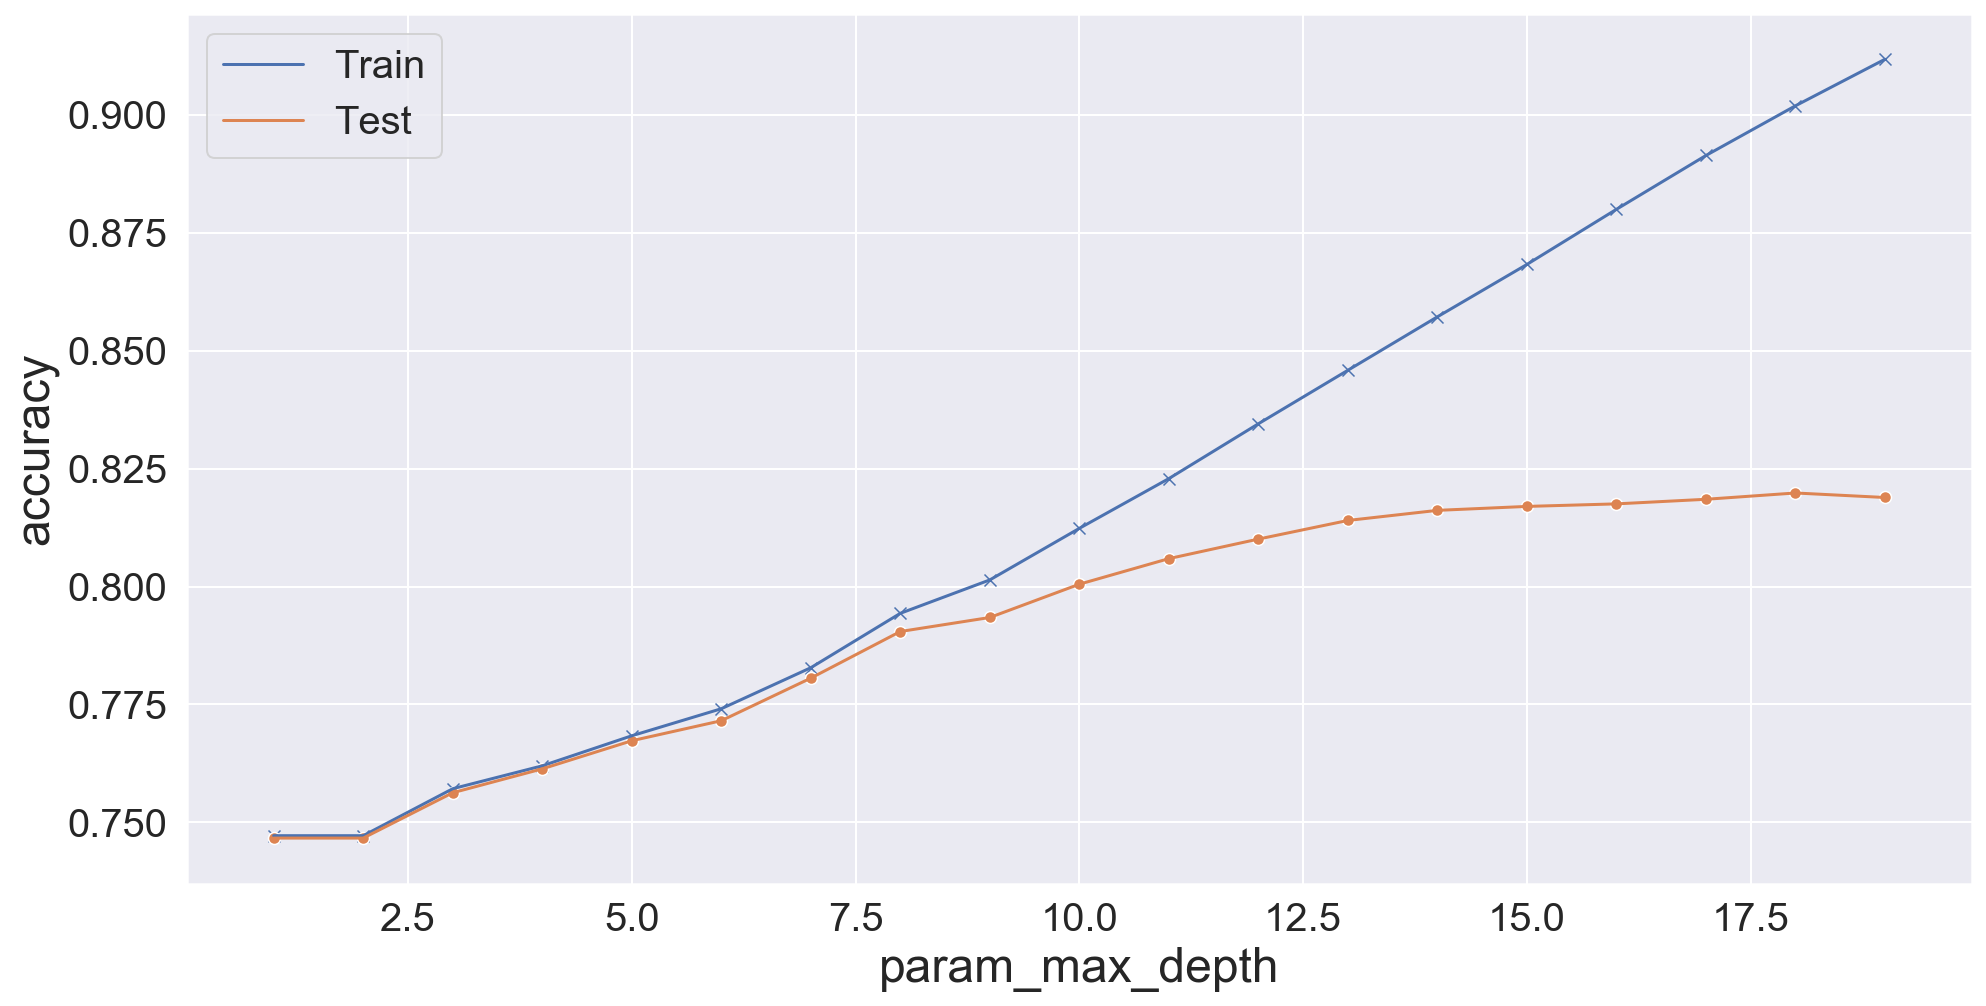

In [12]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(
    DecisionTreeClassifier(criterion="entropy", random_state=0),
    param_grid={"max_depth": list(range(1, 20))},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)
gs.fit(x, y_class)
plot_grid_search_results(gs)
plt.ylabel("accuracy");

We see the test and training accuracy diverges after a tree depth of 8 or so, and the test accuracy plateaus after a tree depth of 15 or so. A relatively good accuracy of around 80% can be achieved. Let's visualize the tree structure.

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.2)

decision_tree = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=8)
decision_tree.fit(x_train, y_train)

# We can export this to a graphviz dot file, which can be used to generate a nice plot.
export_graphviz(decision_tree, out_file="metal_insulator_tree.dot", feature_names=list(x.columns))

Let's see what happens when we change the pruning parameter.

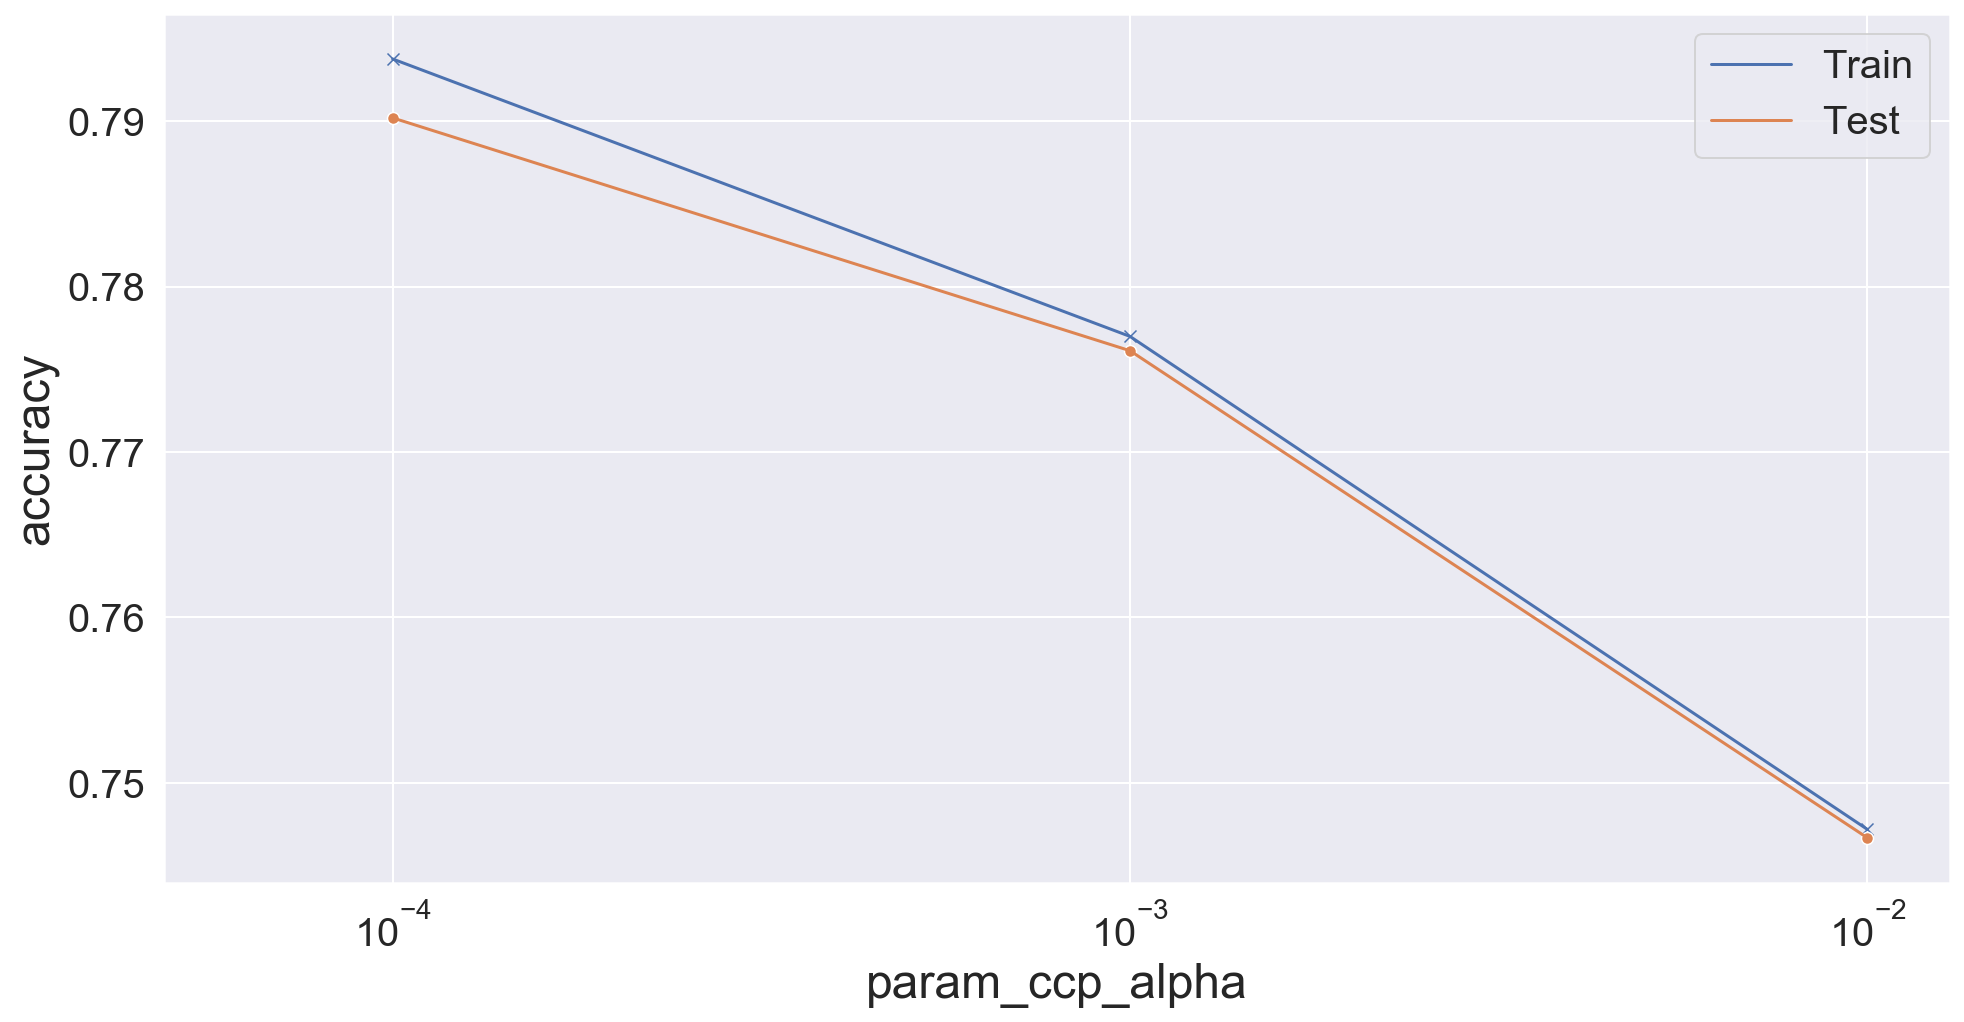

In [14]:
decision_tree = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=8)
gs = GridSearchCV(
    decision_tree,
    param_grid={"ccp_alpha": [1e-4, 1e-3, 1e-2]},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)
gs.fit(x, y_class)
plot_grid_search_results(gs)
plt.ylabel("accuracy")
plt.xscale('log');

As we increase $\alpha$, we decrease the accuracy, but the tree depth decreases.

Let us now visualize a smaller tree to see how decisions are made.

In [15]:
decision_tree = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=3)
decision_tree.fit(x_train, y_train)
r = export_text(decision_tree, feature_names=list(x.columns))
print(r)

|--- ElectronegativityMean <= 2.03
|   |--- ColumnMin <= 2.50
|   |   |--- ElectronegativityMax <= 5.09
|   |   |   |--- class: 0
|   |   |--- ElectronegativityMax >  5.09
|   |   |   |--- class: 1
|   |--- ColumnMin >  2.50
|   |   |--- ColumnMax <= 44.50
|   |   |   |--- class: 0
|   |   |--- ColumnMax >  44.50
|   |   |   |--- class: 0
|--- ElectronegativityMean >  2.03
|   |--- AtomicRadiusMean <= 0.97
|   |   |--- RowMean <= 2.48
|   |   |   |--- class: 1
|   |   |--- RowMean >  2.48
|   |   |   |--- class: 1
|   |--- AtomicRadiusMean >  0.97
|   |   |--- ColumnMax <= 31.00
|   |   |   |--- class: 0
|   |   |--- ColumnMax >  31.00
|   |   |   |--- class: 1



## Feature importance

A very useful of decision trees is that we can visualize the feature importance quite easily.

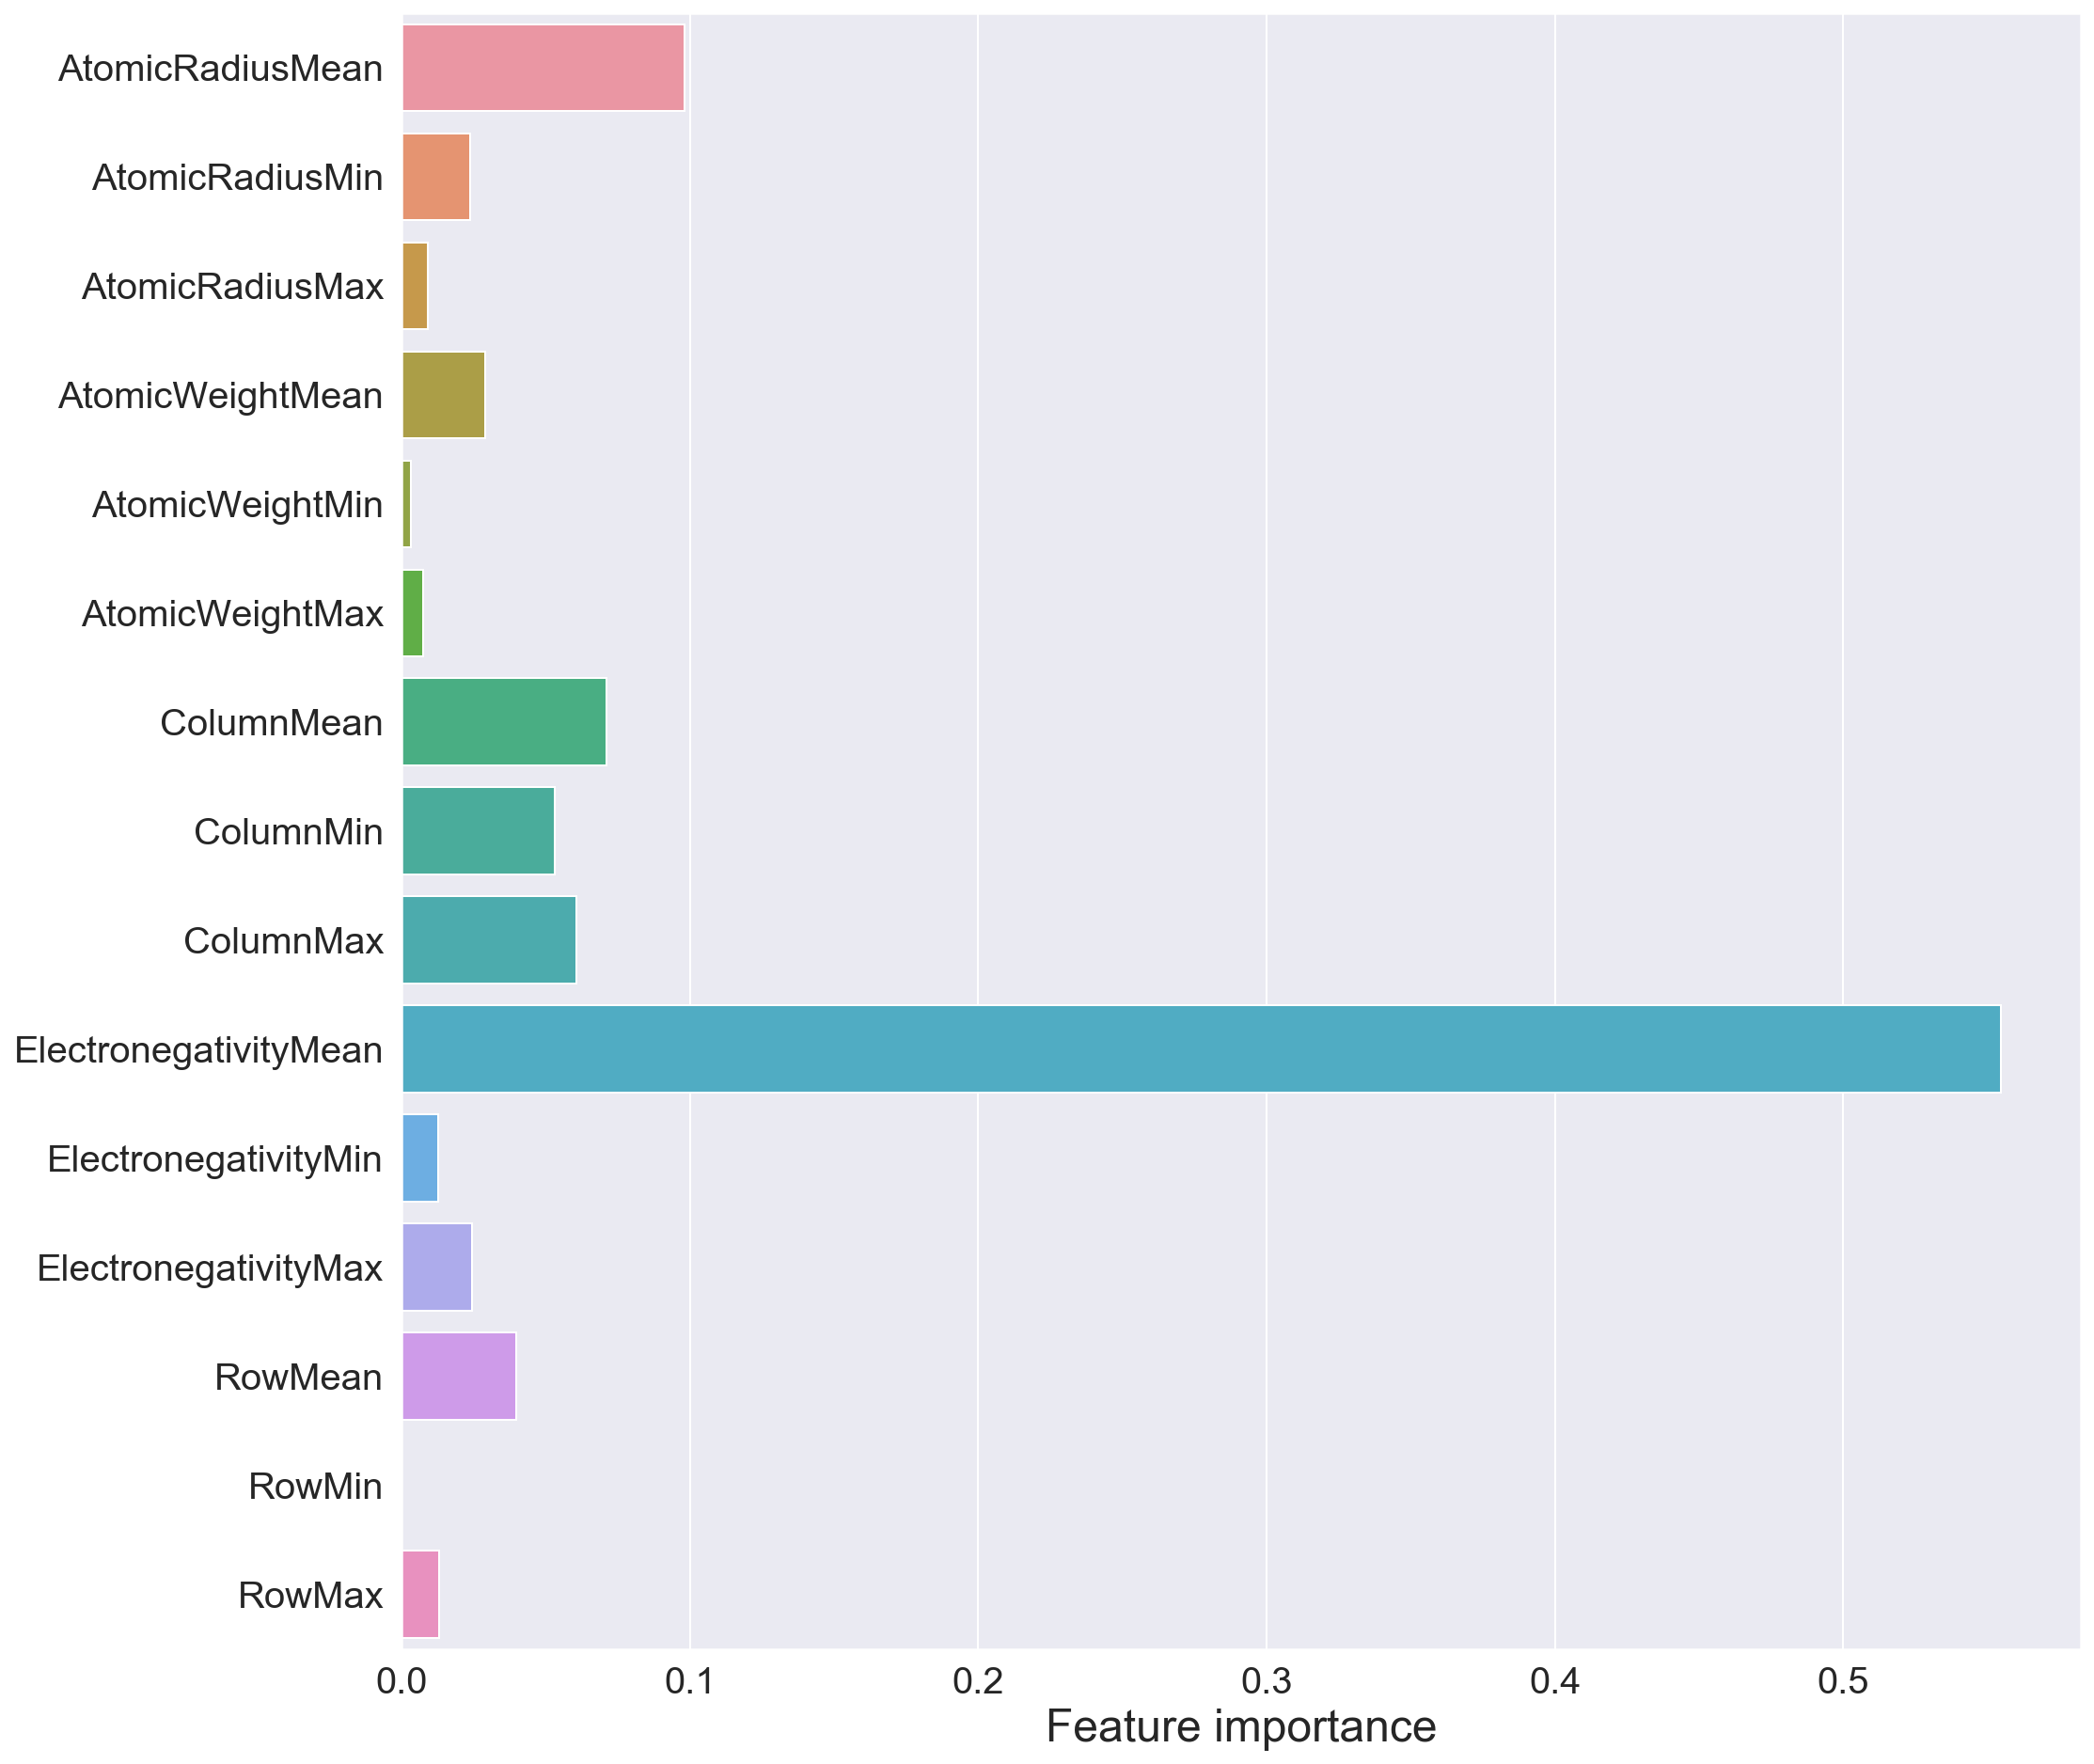

In [16]:
decision_tree = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=8)
decision_tree.fit(x_train, y_train)
plt.subplots(figsize=(16, 16))
sns.barplot(decision_tree.feature_importances_, list(x.columns), orient='h')
plt.xlabel("Feature importance");

## Receiver Operating Characteristic Curve

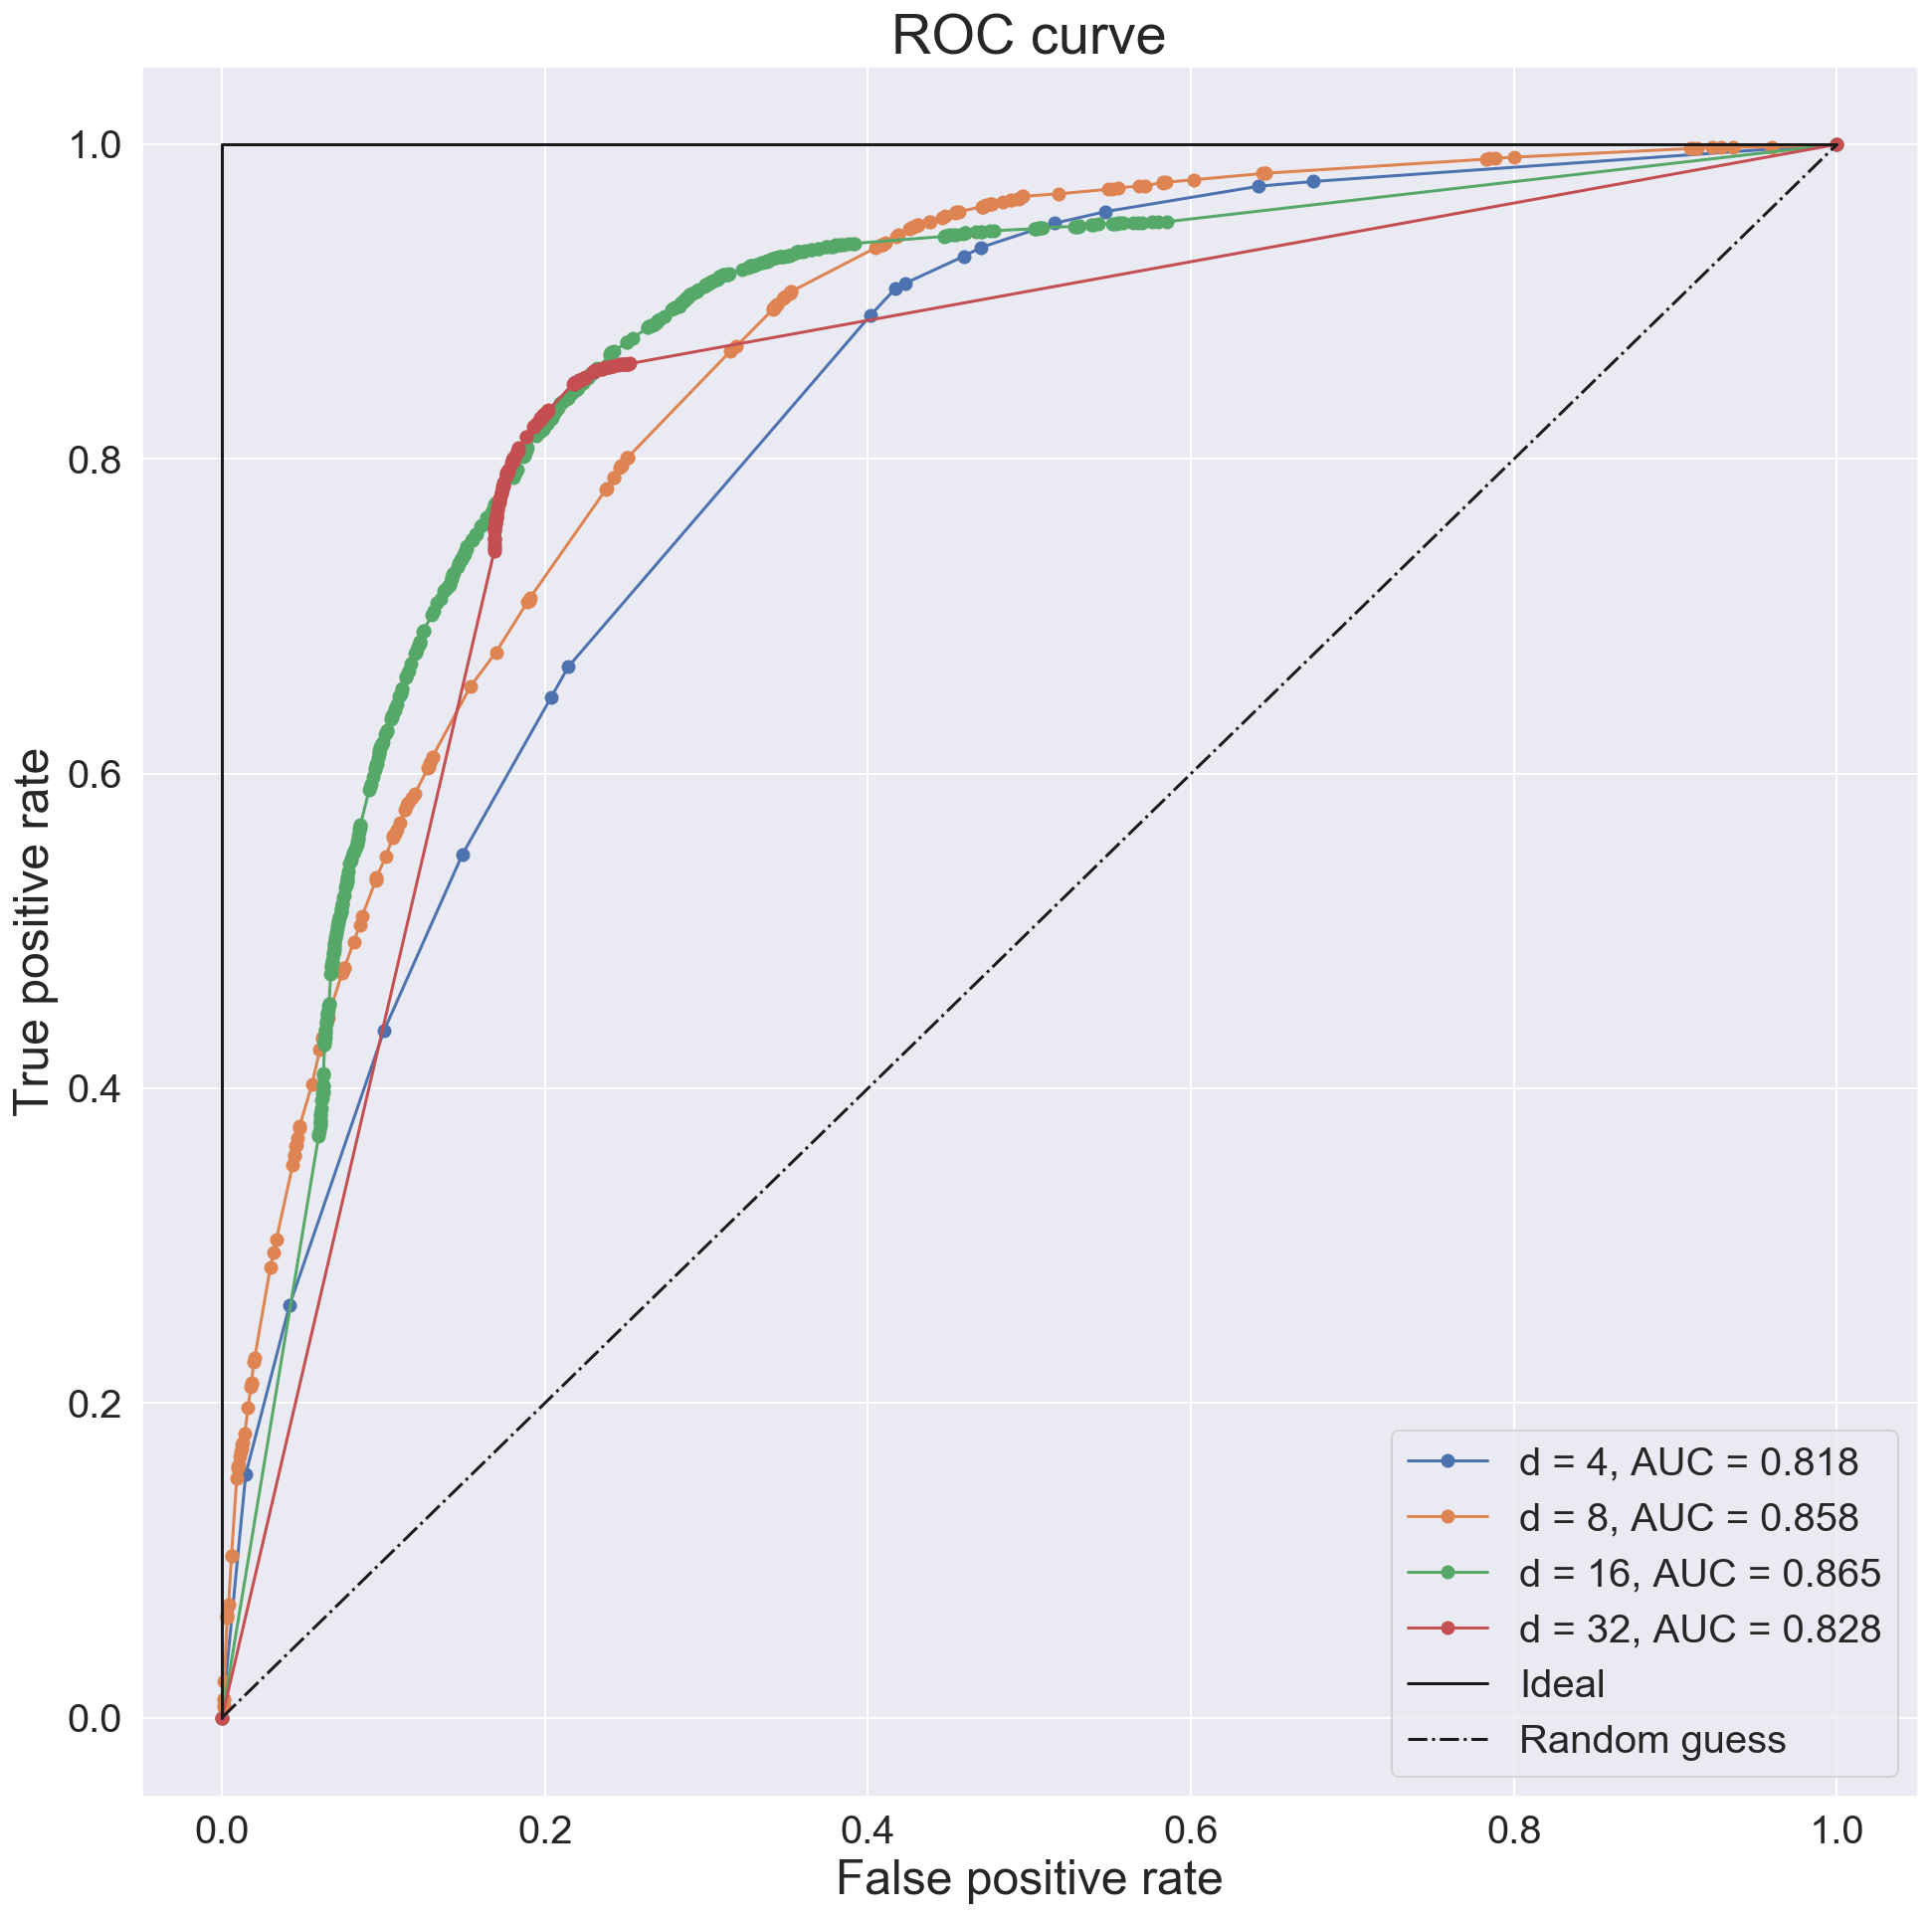

In [17]:
plt.subplots(figsize=(16, 16))
for d in [4, 8, 16, 32]:
    decision_tree = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=d)
    decision_tree = decision_tree.fit(x_train, y_train)
    train_accuracy = decision_tree.score(x_train, y_train)
    test_accuracy = decision_tree.score(x_test, y_test)

    y_pred = decision_tree.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    a = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, 'o-', label='d = %d, AUC = %.3f' % (d, a))

plt.plot([0, 0, 1], [0, 1, 1], 'k-', label="Ideal")
plt.plot([0, 1], [0, 1], 'k-.', label="Random guess")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best');

# Decision Tree Regressor

Instead of just classifying metals and insulators, let us now use the decision tree for regression instead. Here, we will use MSE instead of classification accuracy as the criterion.

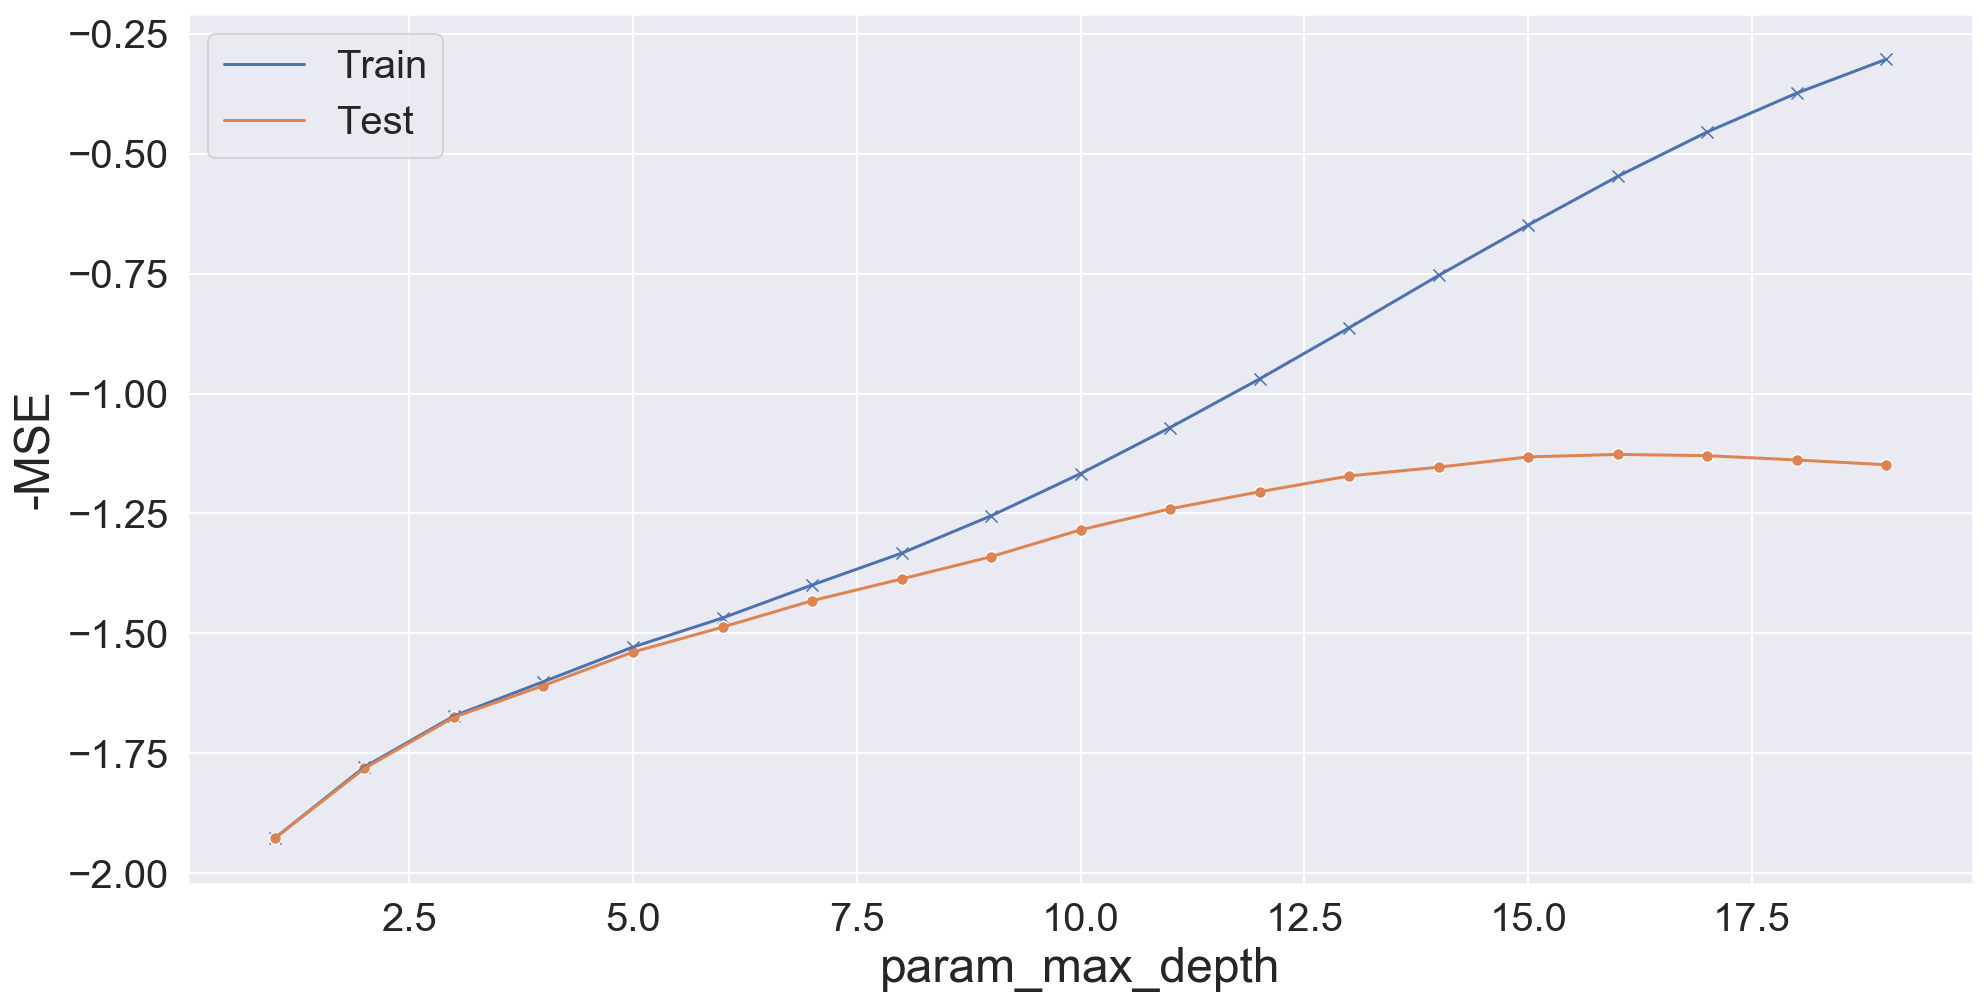

In [18]:
decision_tree = DecisionTreeRegressor(criterion="mse", random_state=0)
gs = GridSearchCV(
    decision_tree,
    param_grid={"max_depth": range(1, 20)},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("-MSE");

We observe that an optimal tree depth of around 15 or so in terms of minimizing MSE. We can achieve a MSE of slightly more than 1 eV. Not great, but reasonable for such a simple model. Let us now explore how alpha affects the tree depth and the MSE.

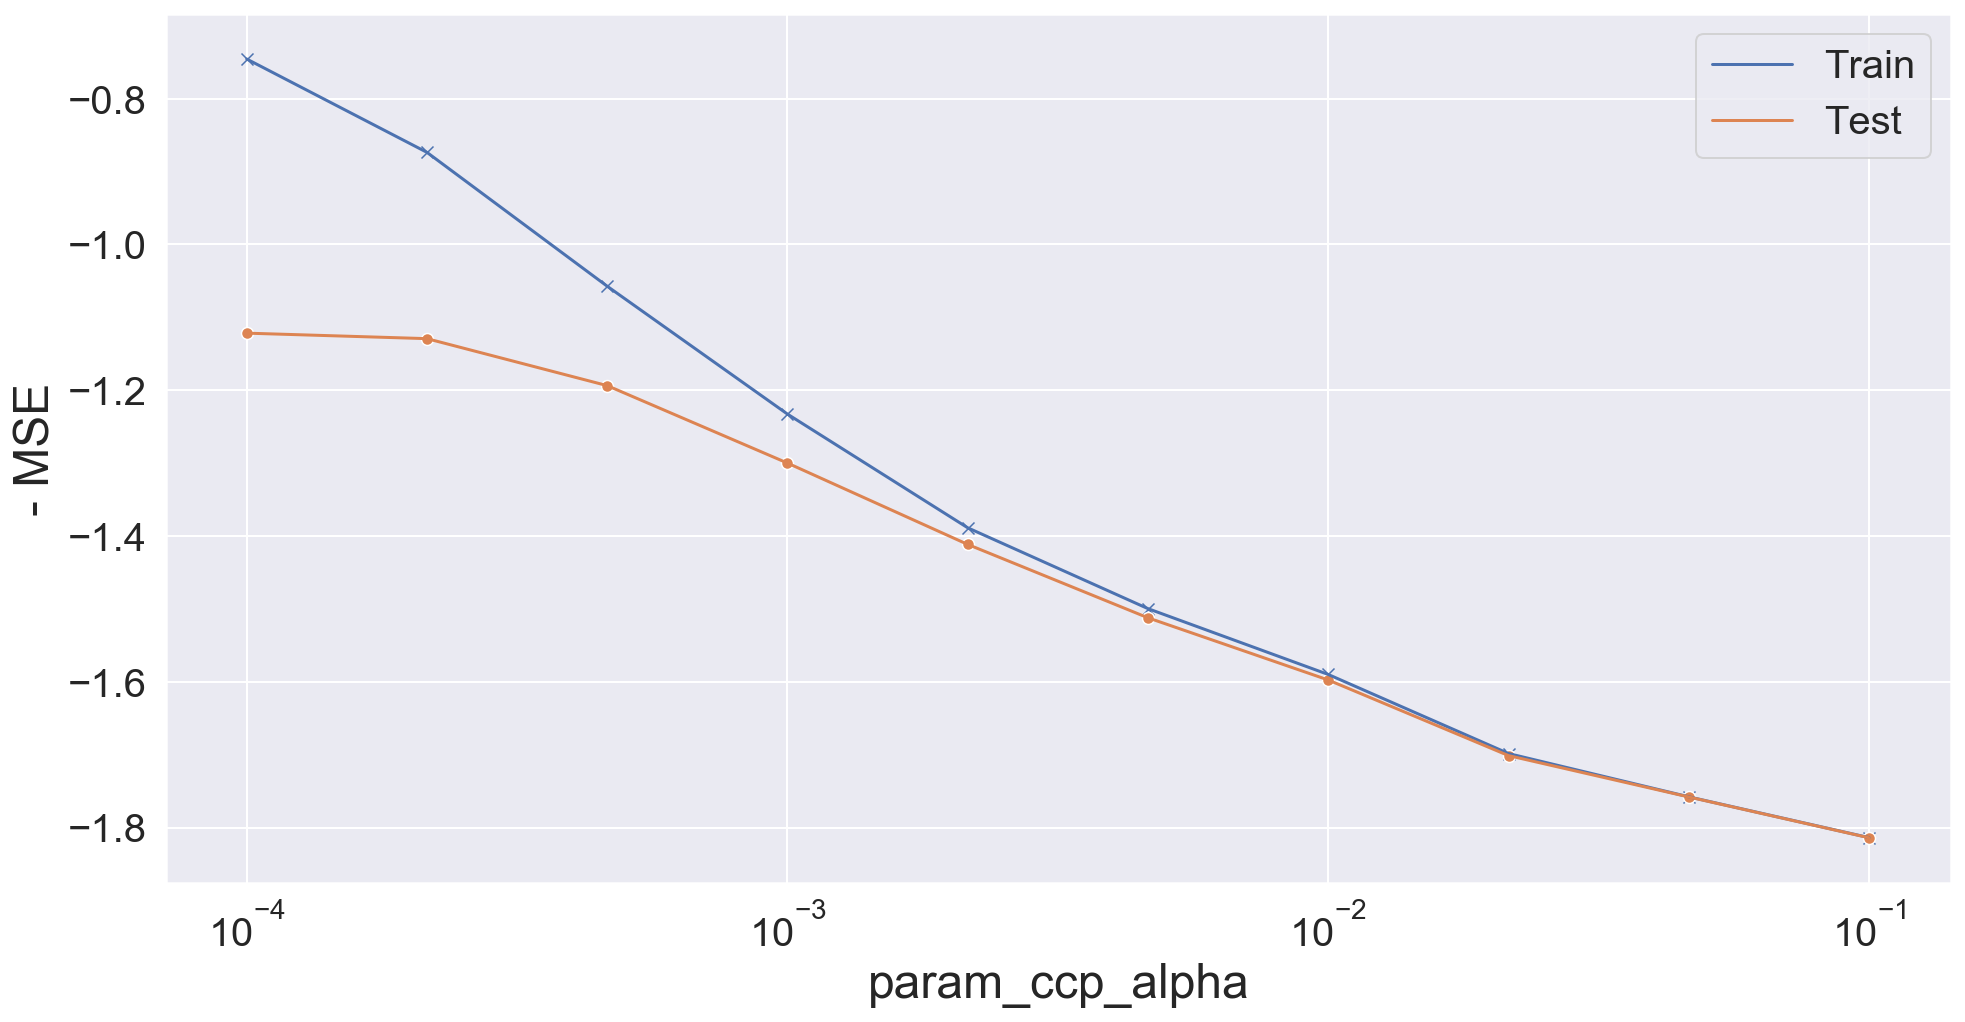

In [19]:
decision_tree = DecisionTreeRegressor(criterion="mse", random_state=0, max_depth=15)

gs = GridSearchCV(
    decision_tree,
    param_grid={"ccp_alpha": np.logspace(-4, -1, 10)},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("- MSE")
plt.xscale('log');

As we increase $\alpha$, we get a simpler (shallower) tree, but the MSE increases. However, the training and test error converges and we get less overfitting.

Let's look at a relatively small tree.

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y_reg, test_size=0.2)

decision_tree = DecisionTreeRegressor(criterion="mse", random_state=0, max_depth=15, ccp_alpha=0.01)
decision_tree.fit(x_train, y_train)
y_pred = decision_tree.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r = export_text(decision_tree, feature_names=list(x.columns))
print("MSE = %.3f" % (mse))
print(r)

MSE = 1.619
|--- ElectronegativityMean <= 2.24
|   |--- RowMean <= 1.99
|   |   |--- value: [3.56]
|   |--- RowMean >  1.99
|   |   |--- ElectronegativityMean <= 1.96
|   |   |   |--- value: [0.13]
|   |   |--- ElectronegativityMean >  1.96
|   |   |   |--- ColumnMin <= 2.50
|   |   |   |   |--- value: [1.29]
|   |   |   |--- ColumnMin >  2.50
|   |   |   |   |--- value: [0.48]
|--- ElectronegativityMean >  2.24
|   |--- AtomicWeightMean <= 20.46
|   |   |--- AtomicRadiusMax <= 2.57
|   |   |   |--- value: [3.61]
|   |   |--- AtomicRadiusMax >  2.57
|   |   |   |--- AtomicWeightMean <= 16.39
|   |   |   |   |--- value: [3.06]
|   |   |   |--- AtomicWeightMean >  16.39
|   |   |   |   |--- value: [2.06]
|   |--- AtomicWeightMean >  20.46
|   |   |--- ColumnMin <= 3.50
|   |   |   |--- ElectronegativityMean <= 2.73
|   |   |   |   |--- AtomicRadiusMin <= 1.18
|   |   |   |   |   |--- value: [2.30]
|   |   |   |   |--- AtomicRadiusMin >  1.18
|   |   |   |   |   |--- value: [1.36]
|   |  

# Adaboost

Here, we will explore the use of boosting with the decision trees above to improve predictions. For classification, we will use a relatively small decision tree with depth 3.

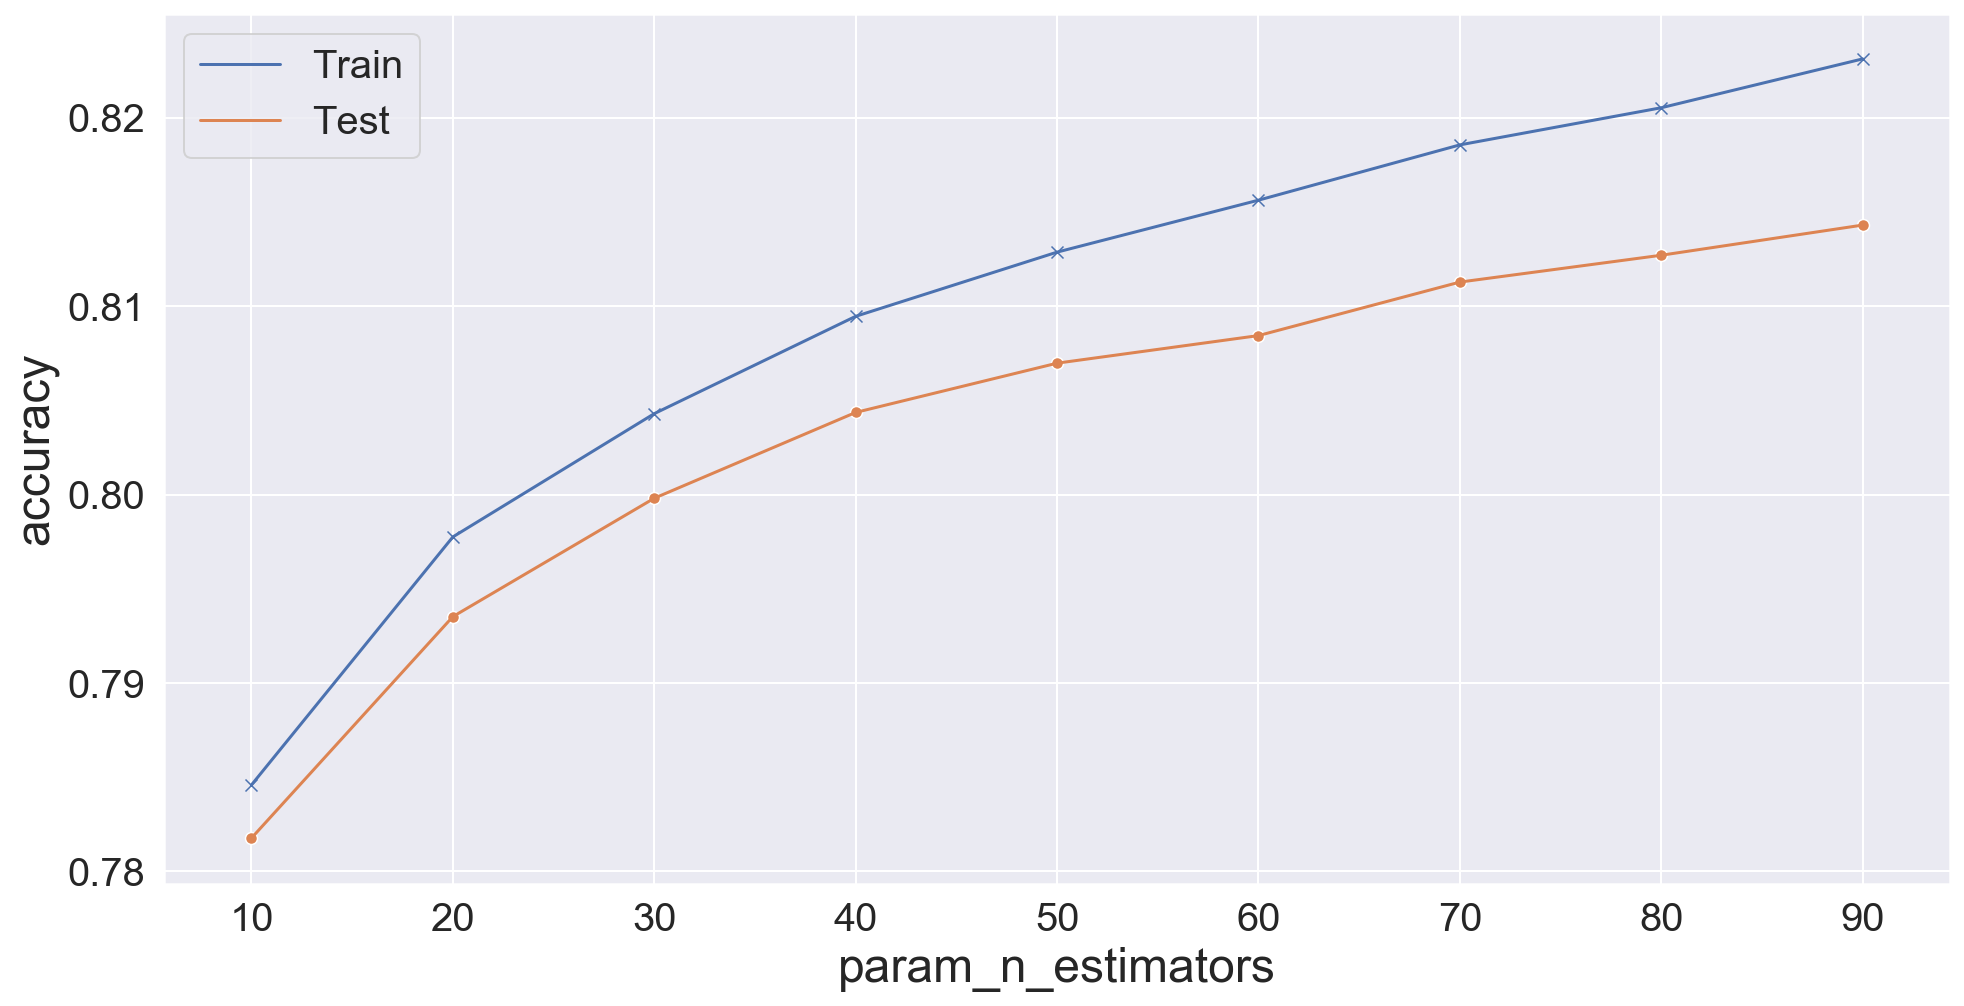

In [21]:
model = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=3))

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": range(10, 100, 10)},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)
gs.fit(x, y_class)
plot_grid_search_results(gs)
plt.ylabel("accuracy");

We can see that even with a small tree, boosting allows us to achieve higher classification accuracies. There is some evidence of overfitting, as can be seen from the divergence of the training and test accuracies. We can of course play around with the tree depth as well as the learning rate to improve the results.

For regression, we will use a decision tree with a max depth of 15 and a lower learning rate.

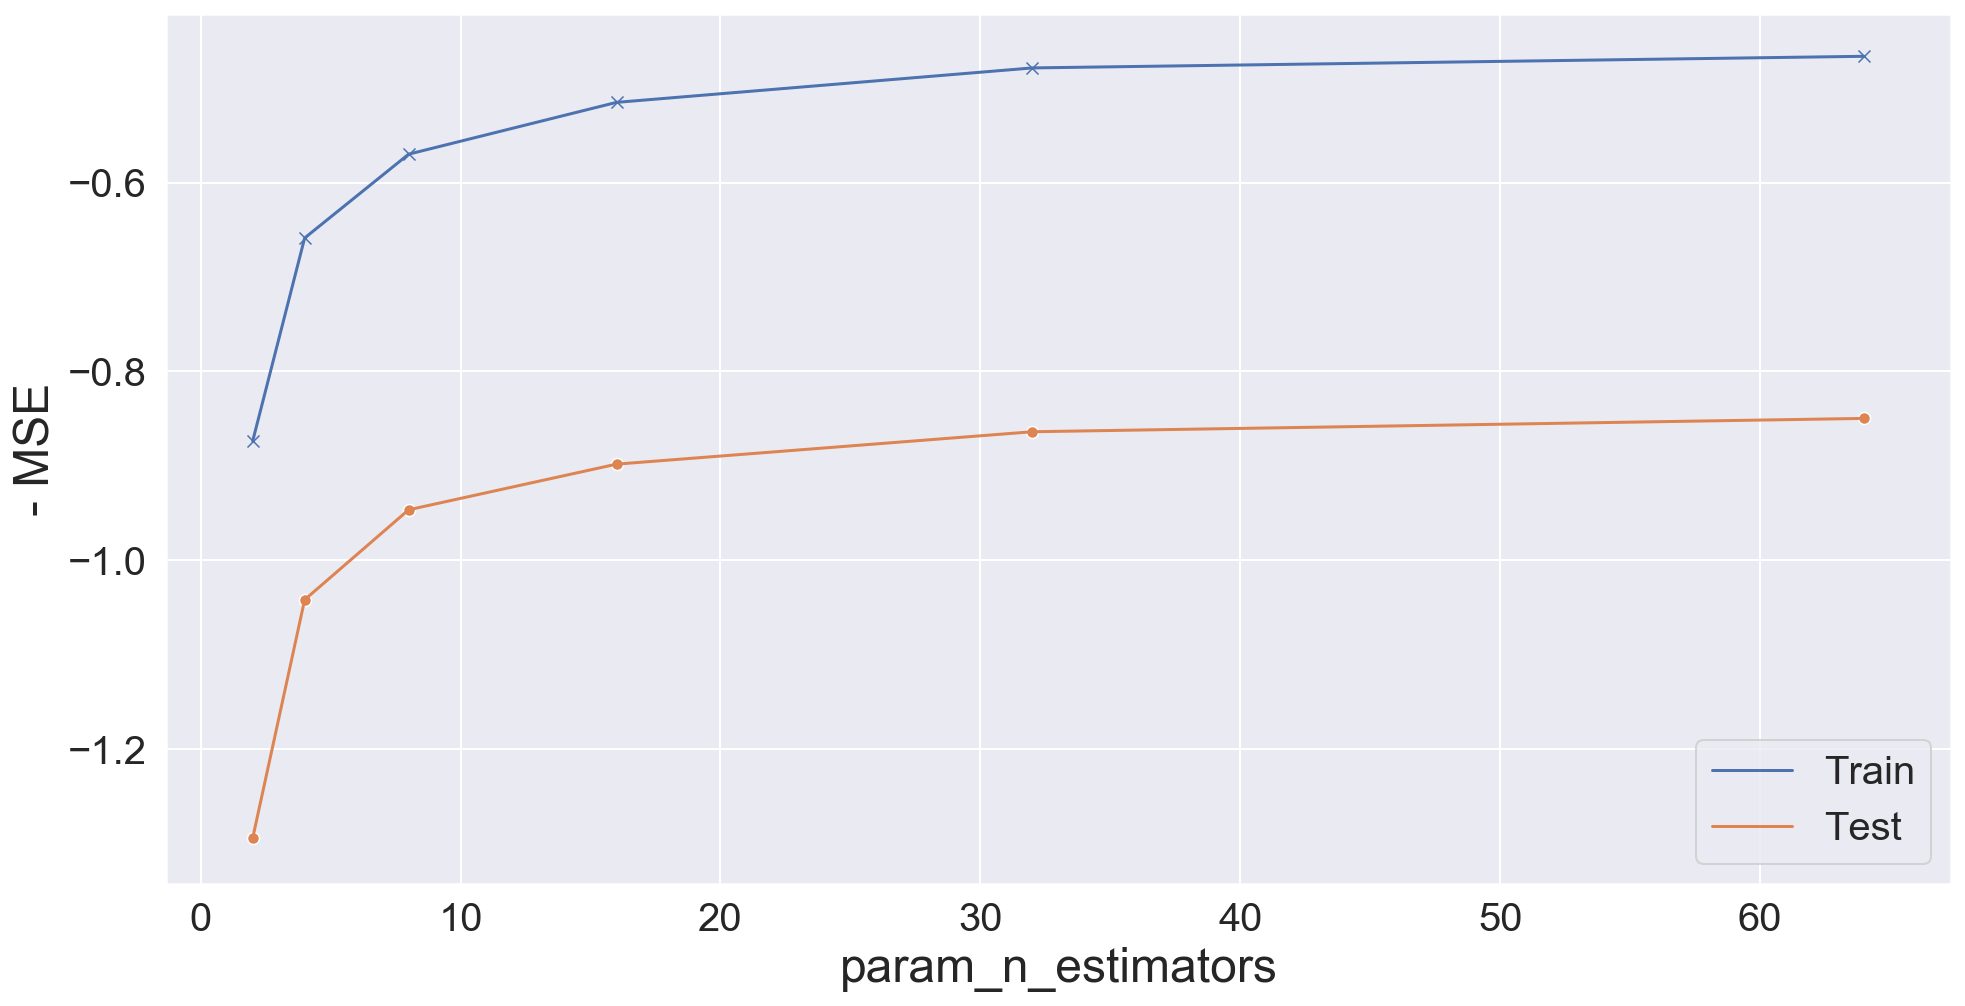

In [22]:
model = AdaBoostRegressor(DecisionTreeRegressor(criterion="mse", random_state=0, max_depth=15), 
                          learning_rate=0.1)

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": [2, 4, 8, 16, 32, 64]},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("- MSE");

We can see that we can get to a substantially lower test MSE of 0.85 eV or so with boosting, albeit with some evidence of over-fitting.